In [11]:
import numpy as np
import pandas as pd
import os, datetime
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
print('Tensorflow version: {}'.format(tf.__version__))

import matplotlib.pyplot as plt
plt.style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')

Tensorflow version: 2.5.0


In [12]:
# btc_path = './Data/BTC_Daily_History_20150101_20210427.csv'
btc_path = './Data/BTC_3hrs_History_20150101_20210427.csv'
df = pd.read_csv(btc_path, delimiter=',', usecols=['time_period_start', 'price_open', 'price_high', 'price_low', 'price_close', 'volume_traded'])
df = df.rename(columns={"time_period_start": "Date", "price_open": "Open", "price_high": "High", "price_low": "Low", "price_close": "Close", "volume_traded": "Volume"})
# Replace 0 to avoid dividing by 0 later on
df['Volume'].replace(to_replace=0, method='ffill', inplace=True) 
df.sort_values('Date', inplace=True)
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d %H:%M')#.dt.date
df.tail()

,Date,Open,High,Low,Close,Volume
18449,2021-04-27 09:00:00+00:00,54507.73,55326.00,54353.50,55215.80,3846.648882
18450,2021-04-27 12:00:00+00:00,55207.00,55363.80,54422.34,55044.21,6517.213363
18451,2021-04-27 15:00:00+00:00,55044.83,55414.00,54270.66,54959.55,7037.888419
18452,2021-04-27 18:00:00+00:00,54959.55,55260.32,54686.03,55192.24,3233.275262
18453,2021-04-27 21:00:00+00:00,55192.24,55542.39,54800.00,55069.62,2572.163529


Rolling

In [13]:
df.dropna(how='any', axis=0, inplace=True)
df.head()

,Date,Open,High,Low,Close,Volume
0,2015-01-01 00:00:00+00:00,321.00,321.00,317.50,317.87,172.545406
1,2015-01-01 03:00:00+00:00,318.42,318.59,312.60,313.98,837.850565
2,2015-01-01 06:00:00+00:00,314.70,317.11,314.34,316.27,148.678824
3,2015-01-01 09:00:00+00:00,316.01,318.25,314.41,315.57,530.374253
4,2015-01-01 12:00:00+00:00,315.57,317.37,313.68,315.12,362.291142


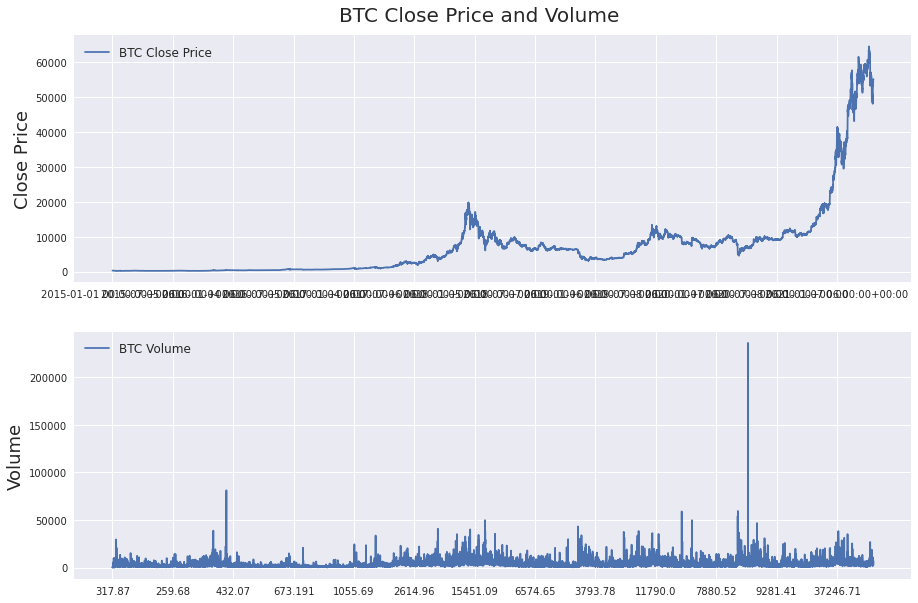

In [14]:
fig = plt.figure(figsize=(15,10))
st = fig.suptitle("BTC Close Price and Volume", fontsize=20)
st.set_y(0.92)

ax1 = fig.add_subplot(211)
ax1.plot(df['Close'], label='BTC Close Price')
ax1.set_xticks(range(0, df.shape[0], 1464))
ax1.set_xticklabels(df['Date'].loc[::1464])
ax1.set_ylabel('Close Price', fontsize=18)
ax1.legend(loc="upper left", fontsize=12)

ax2 = fig.add_subplot(212)
ax2.plot(df['Volume'], label='BTC Volume')
ax2.set_xticks(range(0, df.shape[0], 1464))
ax2.set_xticklabels(df['Close'].loc[::1464])
ax2.set_ylabel('Volume', fontsize=18)
ax2.legend(loc="upper left", fontsize=12)

In [15]:
'''Create indexes to split dataset'''
times = sorted(df.index.values)
print(len(times))
last_10pct = sorted(df.index.values)[-int(0.1*len(times))] # Last 10% of series
last_20pct = sorted(df.index.values)[-int(0.2*len(times))] # Last 20% of series

18454


In [16]:
df.tail()

,Date,Open,High,Low,Close,Volume
18449,2021-04-27 09:00:00+00:00,54507.73,55326.00,54353.50,55215.80,3846.648882
18450,2021-04-27 12:00:00+00:00,55207.00,55363.80,54422.34,55044.21,6517.213363
18451,2021-04-27 15:00:00+00:00,55044.83,55414.00,54270.66,54959.55,7037.888419
18452,2021-04-27 18:00:00+00:00,54959.55,55260.32,54686.03,55192.24,3233.275262
18453,2021-04-27 21:00:00+00:00,55192.24,55542.39,54800.00,55069.62,2572.163529


In [17]:

'''Create training, validation and test split'''

df_train = df[(df.index < last_20pct)]  # Training data are 80% of total data
df_val = df[(df.index >= last_20pct) & (df.index < last_10pct)]
df_test = df[(df.index >= last_10pct)]

# Remove date column
df_train.drop(columns=['Date'], inplace=True)
df_val.drop(columns=['Date'], inplace=True)
df_test.drop(columns=['Date'], inplace=True)

# Data normalization 
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# df_train[['Open', 'High', 'Low', 'Close']] = scaler.fit_transform(df_train[['Open', 'High', 'Low', 'Close']])
# df_train[['Volume']] = scaler.fit_transform(df_train[['Volume']])

# df_val[['Open', 'High', 'Low', 'Close']] = scaler.fit_transform(df_val[['Open', 'High', 'Low', 'Close']])
# df_val[['Volume']] = scaler.fit_transform(df_val[['Volume']])

# df_test[['Open', 'High', 'Low', 'Close']] = scaler.fit_transform(df_test[['Open', 'High', 'Low', 'Close']])
# df_test[['Volume']] = scaler.fit_transform(df_test[['Volume']])

# Convert pandas columns into arrays
train_data = df_train.values
val_data = df_val.values
test_data = df_test.values
print('Training data shape: {}'.format(train_data.shape))
print('Validation data shape: {}'.format(val_data.shape))
print('Test data shape: {}'.format(test_data.shape))

df_train.head()

Training data shape: (14764, 5)
Validation data shape: (1845, 5)
Test data shape: (1845, 5)


,Open,High,Low,Close,Volume
0,321.00,321.00,317.50,317.87,172.545406
1,318.42,318.59,312.60,313.98,837.850565
2,314.70,317.11,314.34,316.27,148.678824
3,316.01,318.25,314.41,315.57,530.374253
4,315.57,317.37,313.68,315.12,362.291142


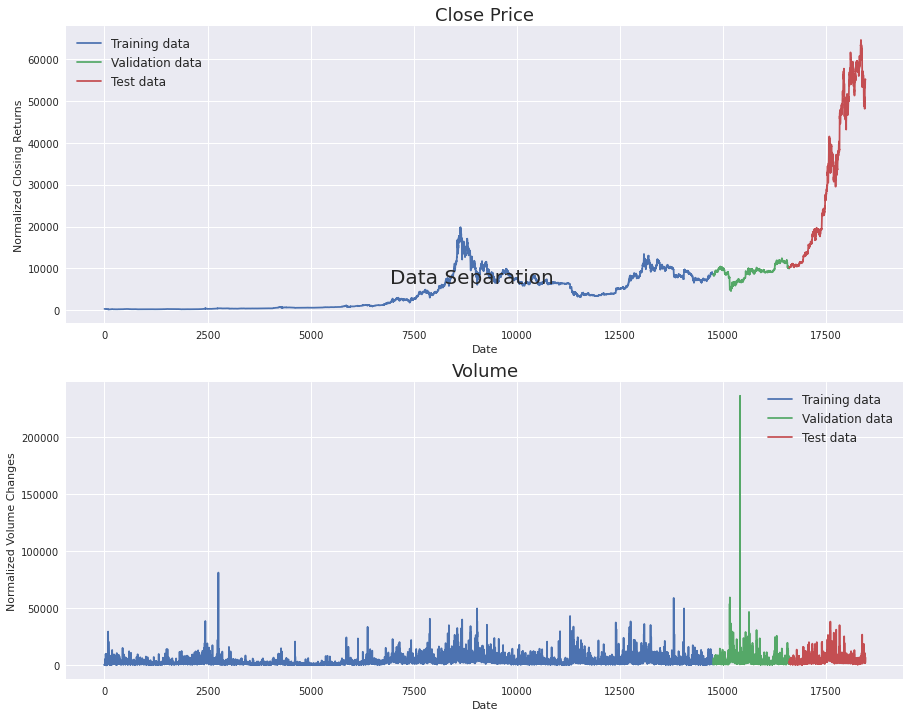

In [18]:
fig = plt.figure(figsize=(15,12))
st = fig.suptitle("Data Separation", fontsize=20)
st.set_y(0.6)

###############################################################################

ax1 = fig.add_subplot(211)
ax1.plot(np.arange(train_data.shape[0]), df_train['Close'], label='Training data')

ax1.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['Close'], label='Validation data')

ax1.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['Close'], label='Test data')
ax1.set_xlabel('Date')
ax1.set_ylabel('Normalized Closing Returns')
ax1.set_title("Close Price", fontsize=18)
ax1.legend(loc="best", fontsize=12)

###############################################################################

ax2 = fig.add_subplot(212)
ax2.plot(np.arange(train_data.shape[0]), df_train['Volume'], label='Training data')

ax2.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['Volume'], label='Validation data')

ax2.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['Volume'], label='Test data')
ax2.set_xlabel('Date')
ax2.set_ylabel('Normalized Volume Changes')
ax2.set_title("Volume", fontsize=18)
ax2.legend(loc="best", fontsize=12)

In [19]:
seq_len = 240

# Training data
X_train, y_train = [], []
for i in range(seq_len, len(train_data)):
  X_train.append(train_data[i-seq_len:i]) # Chunks of training data with a length of 240 df-rows
  y_train.append(train_data[:, 3][i]) #Value of 4th column (Close Price) of df-row 240+1
X_train, y_train = np.array(X_train), np.array(y_train)

###############################################################################

# Validation data
X_val, y_val = [], []
for i in range(seq_len, len(val_data)):
    X_val.append(val_data[i-seq_len:i])
    y_val.append(val_data[:, 3][i])
X_val, y_val = np.array(X_val), np.array(y_val)

###############################################################################

# Test data
X_test, y_test = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[i-seq_len:i])
    y_test.append(test_data[:, 3][i])    
X_test, y_test = np.array(X_test), np.array(y_test)

print('Training set shape', X_train.shape, y_train.shape)
print('Validation set shape', X_val.shape, y_val.shape)
print('Testing set shape' ,X_test.shape, y_test.shape)

Training set shape (14524, 240, 5) (14524,)
Validation set shape (1605, 240, 5) (1605,)
Testing set shape (1605, 240, 5) (1605,)


In [20]:
'''Build model'''
model_name = 'lstm_btc_with_no_norm.hdf5'
batch_size = 32

from keras.models import Sequential 
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout

def build_model(inputs, output_size, neurons, activ_func='linear', dropout=0.25, loss='mse', optimizer='adam'):
        model = Sequential()
        model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
        model.add(Dropout(dropout))
        model.add(Dense(units=output_size))
        model.add(Activation(activ_func))        
        model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mape'])
        return model

np.random.seed(202)
btc_model = build_model(X_train, output_size=1, neurons=20)
btc_model.summary()

# btc_model_history = btc_model.fit(X_train, y_train, epochs=35, batch_size=1, verbose=2, shuffle=True)
callback = tf.keras.callbacks.ModelCheckpoint(model_name, monitor='val_loss', save_best_only=True, verbose=1)

history = btc_model.fit(X_train, y_train, 
                    batch_size=batch_size, 
                    epochs=35,
                    callbacks=[callback],
                    validation_data=(X_val, y_val)) 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 20)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 21        
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 2,101
Trainable params: 2,101
Non-trainable params: 0
_________________________________________________________________
Epoch 1/35
454/454 [==============================] - 47s 99ms/step - loss: 31748672.2022 - mae: 4009.6723 - mape: 99.7720 - val_loss: 85316792.0000 - val_mae: 9079.3984 - val_mape: 99.9271

Epoch 00001: val_loss improved from inf to 85316792.00000, 

In [21]:
'''Calculate predictions and metrics'''
btc_model = tf.keras.models.load_model(model_name)

#Calculate predication for training, validation and test data
train_pred = btc_model.predict(X_train)
val_pred = btc_model.predict(X_val)
test_pred = btc_model.predict(X_test)

#Print evaluation metrics for all datasets
train_eval = btc_model.evaluate(X_train, y_train, verbose=0)
val_eval = btc_model.evaluate(X_val, y_val, verbose=0)
test_eval = btc_model.evaluate(X_test, y_test, verbose=0)

In [23]:

print(' ')
print('Evaluation metrics')
print('Training Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(train_eval[0], train_eval[1], train_eval[2]))
print('Validation Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(val_eval[0], val_eval[1], val_eval[2]))
print('Test Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(test_eval[0], test_eval[1], test_eval[2]))

 
Evaluation metrics
Training Data - Loss: 30421022.0000, MAE: 3842.6794, MAPE: 74.1823
Validation Data - Loss: 81803288.0000, MAE: 8882.9375, MAPE: 97.6662
Test Data - Loss: 1517243264.0000, MAE: 34980.1836, MAPE: 99.2676


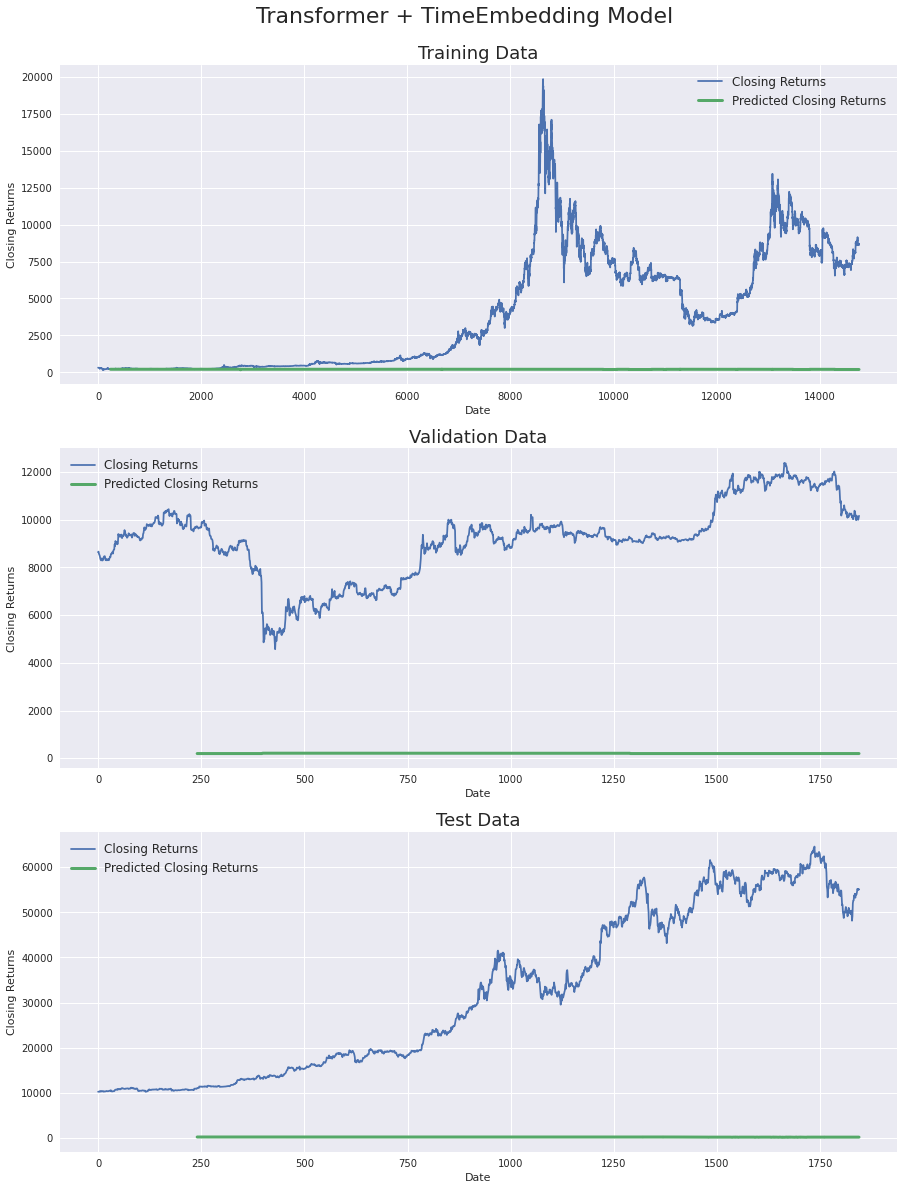

In [24]:
###############################################################################
'''Display results'''

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Transformer + TimeEmbedding Model", fontsize=22)
st.set_y(0.92)

#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(train_data[:, 3], label='Closing Returns')
ax11.plot(np.arange(seq_len, train_pred.shape[0]+seq_len), train_pred, linewidth=3, label='Predicted Closing Returns')
ax11.set_title("Training Data", fontsize=18)
ax11.set_xlabel('Date')
ax11.set_ylabel('Closing Returns')
ax11.legend(loc="best", fontsize=12)

#Plot validation data results
ax21 = fig.add_subplot(312)
ax21.plot(val_data[:, 3], label='Closing Returns')
ax21.plot(np.arange(seq_len, val_pred.shape[0]+seq_len), val_pred, linewidth=3, label='Predicted Closing Returns')
ax21.set_title("Validation Data", fontsize=18)
ax21.set_xlabel('Date')
ax21.set_ylabel('Closing Returns')
ax21.legend(loc="best", fontsize=12)

#Plot test data results
ax31 = fig.add_subplot(313)
ax31.plot(test_data[:, 3], label='Closing Returns')
ax31.plot(np.arange(seq_len, test_pred.shape[0]+seq_len), test_pred, linewidth=3, label='Predicted Closing Returns')
ax31.set_title("Test Data", fontsize=18)
ax31.set_xlabel('Date')
ax31.set_ylabel('Closing Returns')
ax31.legend(loc="best", fontsize=12)

plt.savefig('35_epoch_no_data_norm_btc_pred.png')

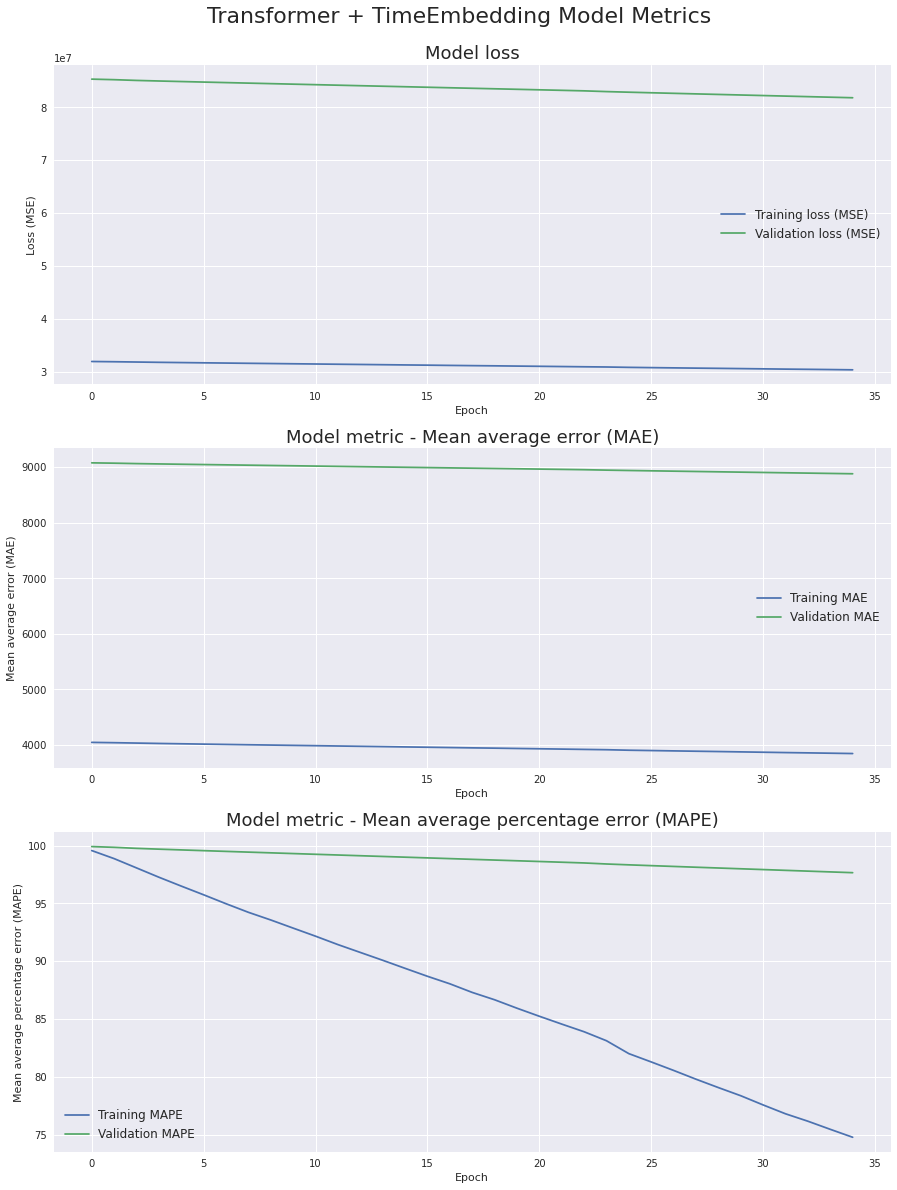

In [25]:
'''Display model metrics'''

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Transformer + TimeEmbedding Model Metrics", fontsize=22)
st.set_y(0.92)

#Plot model loss
ax1 = fig.add_subplot(311)
ax1.plot(history.history['loss'], label='Training loss (MSE)')
ax1.plot(history.history['val_loss'], label='Validation loss (MSE)')
ax1.set_title("Model loss", fontsize=18)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss (MSE)')
ax1.legend(loc="best", fontsize=12)

#Plot MAE
ax2 = fig.add_subplot(312)
ax2.plot(history.history['mae'], label='Training MAE')
ax2.plot(history.history['val_mae'], label='Validation MAE')
ax2.set_title("Model metric - Mean average error (MAE)", fontsize=18)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Mean average error (MAE)')
ax2.legend(loc="best", fontsize=12)

#Plot MAPE
ax3 = fig.add_subplot(313)
ax3.plot(history.history['mape'], label='Training MAPE')
ax3.plot(history.history['val_mape'], label='Validation MAPE')
ax3.set_title("Model metric - Mean average percentage error (MAPE)", fontsize=18)
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Mean average percentage error (MAPE)')
ax3.legend(loc="best", fontsize=12)

plt.savefig('35_epoch_no_data_norm_btc_loss.png')

Model architecture overview

In [ ]:
# tf.keras.utils.plot_model(
#     model,
#     to_file="Transformer+TimeEmbedding.png",
#     show_shapes=True,
#     show_layer_names=True,
#     expand_nested=True,
#     dpi=96,)